In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity: Joint training

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet8j_mpf_evc'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1,2,3,4,5,6,7,8]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Jan-27-2022_1744


# Load the stimuli images
From the subjectwise image preparation

In [5]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

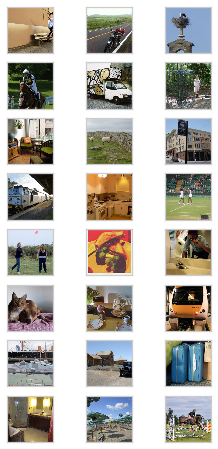

In [6]:
n = 1003
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [7]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [8]:
beta_dir = '/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/'

In [9]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4627
1348 	: V1
1415 	: V2
1188 	: V3
676 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 3765
1097 	: V1
1083 	: V2
1081 	: V3
504 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 3  -------
(81, 106, 82)
full mask length = 704052
selection length = 3778
1251 	: V1
1160 	: V2
945 	: V3
422 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 4  -------
(85, 99, 80)
full mask length = 673200
selection length = 3027
871 	: V1
883 	: V2
800 	: V3
473 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 3685
1115 	: V1
1088 	: V2
934 	: V3
548 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO

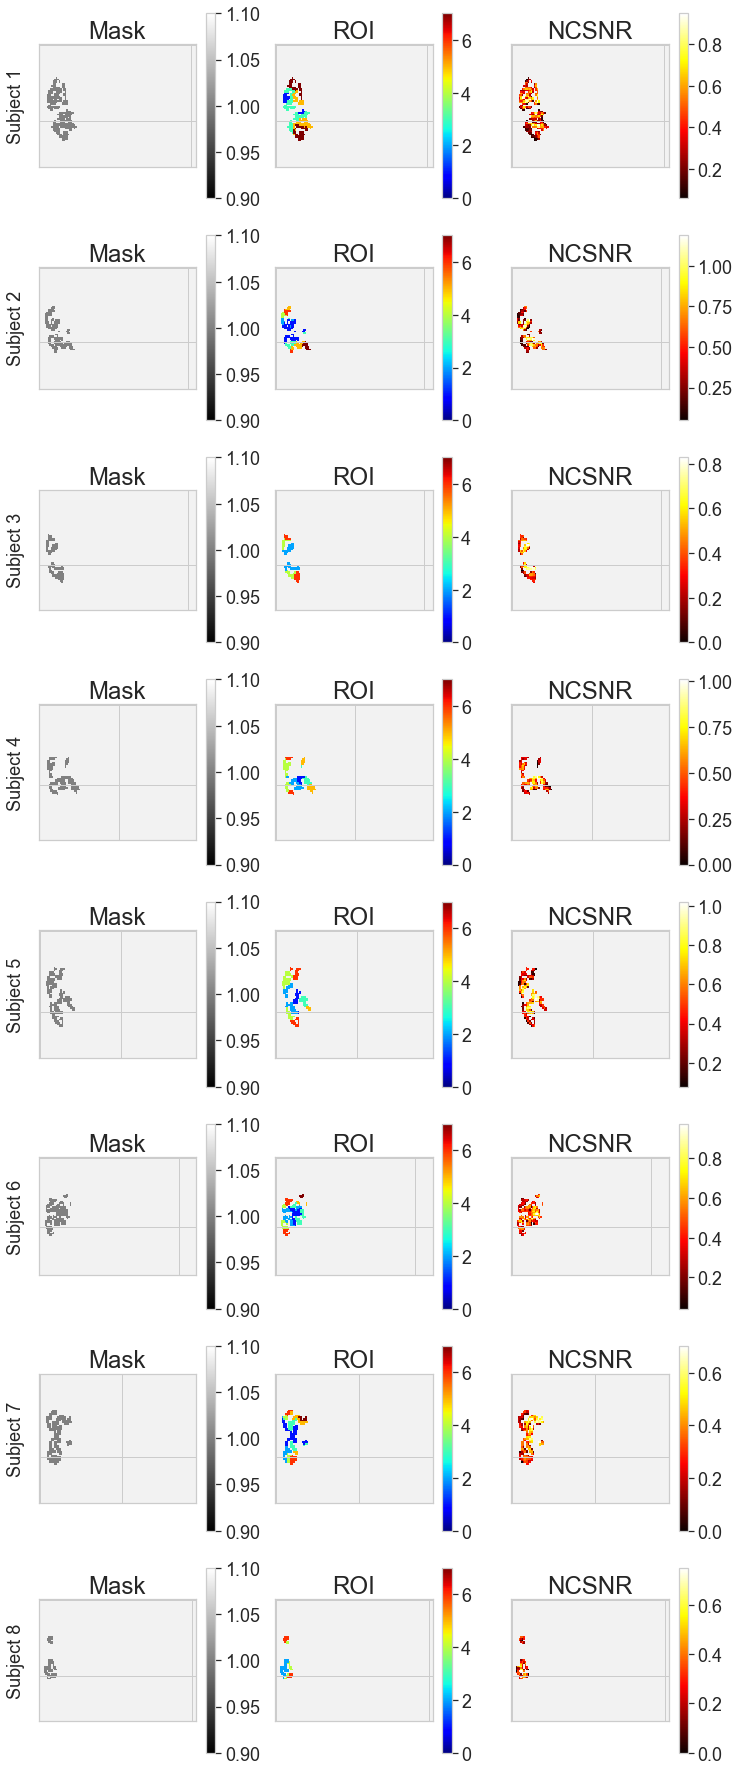

In [10]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [11]:
#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part1.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part1.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']

#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part2.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part2.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {s: voxel_data['%d'%s] for s in voxel_roi.keys()}
print (voxel_data.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])


## Slow load from raw data

In [15]:
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=False, voxel_mask=voxel_mask[s], up_to=-1, load_ext='.nii.gz')
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(voxel_dir + 'voxel_data_general_raw', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 1  -------
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/bet

/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session07.nii.gz
int16 -32768 32767 (750, 82, 106, 84)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session08.nii.gz
int16 -32768 32767 (750, 82, 106, 84)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session09.nii.gz
int16 -32768 32767 (750, 82, 106, 84)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session10.nii.gz
int16 -32768 32767 (750, 82, 106, 84)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session11.nii.gz
int16 -32768 32767 (750, 82, 106, 84)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas

int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session14.nii.gz
int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session15.nii.gz
int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session16.nii.gz
int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session17.nii.gz
int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session18.nii.gz
int16 -32768 32767 (750, 81, 106, 82)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj03/func1

int16 -32768 32767 (750, 85, 99, 80)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.nii.gz
int16 -32768 32767 (750, 85, 99, 80)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session30.nii.gz
int16 -32768 32767 (750, 85, 99, 80)
----------------------------
(22500, 3027)
--------  subject 5  -------
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 79, 97, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
int16 -32768 32767 (750, 79, 97, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz
int16 -32768 32767 (750, 79, 97, 78)
/export/raid1/ho

int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.nii.gz
int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.nii.gz
int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session07.nii.gz
int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session08.nii.gz
int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session09.nii.gz
int16 -32768 32767 (750, 85, 113, 83)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj06/func1

int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session20.nii.gz
int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session21.nii.gz
int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session22.nii.gz
int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session23.nii.gz
int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session24.nii.gz
int16 -32768 32767 (750, 78, 95, 81)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/

int16 -32768 32767 (750, 80, 103, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session27.nii.gz
int16 -32768 32767 (750, 80, 103, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session28.nii.gz
int16 -32768 32767 (750, 80, 103, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.nii.gz
int16 -32768 32767 (750, 80, 103, 78)
/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session30.nii.gz
int16 -32768 32767 (750, 80, 103, 78)
----------------------------
(22500, 3490)
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5py file
saved voxel_mask.6 in h5py file
saved voxel_mask.7 in h

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [12]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4627
--------  subject 2  -------
Total number of voxels = 3765
--------  subject 3  -------
Total number of voxels = 3778
--------  subject 4  -------
Total number of voxels = 3027
--------  subject 5  -------
Total number of voxels = 3685
--------  subject 6  -------
Total number of voxels = 4024
--------  subject 7  -------
Total number of voxels = 3201
--------  subject 8  -------
Total number of voxels = 3490


In [13]:
trn_stim_mean = sum([np.mean(stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47611815]]

  [[0.45324636]]

  [[0.41308543]]]]


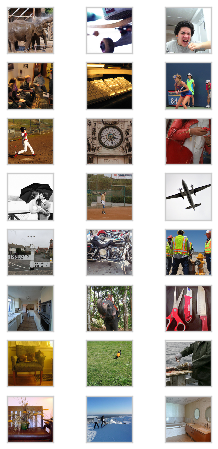

In [14]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Model

In [20]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [17]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [21]:
shared_model = Encoder(trn_stim_mean, trunk_width=64).to(device)
rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

#subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, voxels_map=voxel_roi[s], masks_map=None, pre_nl=_log_act_fn, \
#                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

## Parameter count

In [22]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [4627, 27, 27]  
block size [4627, 14, 14]  
block size [4627, 768]     
block size [4627]          
--------- subject 2 ----------
block size [3765, 27, 27]  
block size [3765, 14, 14]  
block size [3765, 768]     
block size [3765]          
--------- subject 3 ----------
block size [3778, 27, 27]  
block size [3778, 14, 14]  
block size [3778, 768]     
block size [3778]          
--------- subject 4 ----------
block size [3027, 27, 27]  
block size [3027, 14, 14]  
block size [3027, 768]     
block size [3027]          
--------- subject 5 ----------
block size [3685, 27, 27]  
block size [3685, 14, 14]  
block size [3685, 768]     
block size [3685]          
--------- subject 6 ----------
block size [4024, 27, 27]  
block size [4024, 14, 14]  
block size [4024, 768]     
block size [4024]          
--------- subject 7 ----------
block size [3201, 27, 27]  
block size [3201, 14, 14]  
block size [3201, 768]     
block size [3201]          

## Load prefilters value

In [23]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

## Checkpoint reload

In [24]:
#joined_checkpoint = torch.load(output_dir+'model_params_encft')
#
#best_params = joined_checkpoint['best_params']
#shared_model.load_state_dict(best_params['enc'])
#shared_model.eval() 
#for s,sd in subject_fwrfs.items():
#    sd.load_state_dict(best_params['fwrfs'][s])
#    sd.eval() 

# Loss function, grad function, etc.

In [25]:
optimizer_net = optim.Adam([
       #{'params': shared_model.pre.parameters()},
       {'params': shared_model.enc.parameters()},
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
       {'params': sp.parameters()}
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

#subject_opts = {s: [optimizer_net] for s in subject_optimizer.keys()}
#subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}
subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [26]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [28]:
import src.torch_joint_training_unpacked_sequences as aaa
import imp
imp.reload(aaa)

<module 'src.torch_joint_training_unpacked_sequences' from '/export/raid1/home/styvesg/code/nsd/src/torch_joint_training_unpacked_sequences.py'>

In [ ]:
batch_size = 100
num_epochs = 50
holdout_frac = .1

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        stim_data, trn_voxel_data, trn_stim_ordering,
        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)

subject 1 masked 4627 of 4627
subject 1 training/holdout 24300 2700
subject 2 masked 3765 of 3765
subject 2 training/holdout 24300 2700
subject 3 masked 3778 of 3778
subject 3 training/holdout 19466 2163
subject 4 masked 3027 of 3027
subject 4 training/holdout 18280 2032
subject 5 masked 3685 of 3685
subject 5 training/holdout 24300 2700
subject 6 masked 4024 of 4024
subject 6 training/holdout 19466 2163
subject 7 masked 3201 of 3201
subject 7 training/holdout 24300 2700
subject 8 masked 3490 of 3490
subject 8 training/holdout 18280 2032
| : 0.1 %

/export/raid1/home/styvesg/code/nsd/src/torch_joint_training_unpacked_sequences.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  islices = np.array(islices)[ordering]


/ : 1.0 % %

/export/raid1/home/styvesg/code/nsd/src/torch_joint_training_unpacked_sequences.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  islices = np.array(islices)#, dtype=int)


/ : 100.0 %
  Epoch 1 of 50 took       294.490s
  training loss:               0.968780
  holdout loss (batch):        0.961788
  Subject 1: median (max) validation accuracy = 0.167 (0.560)
  Subject 2: median (max) validation accuracy = 0.191 (0.547)
  Subject 3: median (max) validation accuracy = 0.166 (0.457)
  Subject 4: median (max) validation accuracy = 0.169 (0.590)
  Subject 5: median (max) validation accuracy = 0.193 (0.516)
  Subject 6: median (max) validation accuracy = 0.191 (0.612)
  Subject 7: median (max) validation accuracy = 0.129 (0.463)
  Subject 8: median (max) validation accuracy = 0.149 (0.490)
** Saving params with joint score = 0.169 **

/ : 100.0 %
  Epoch 2 of 50 took       295.995s
  training loss:               0.951224
  holdout loss (batch):        0.948546
  Subject 1: median (max) validation accuracy = 0.213 (0.640)
  Subject 2: median (max) validation accuracy = 0.235 (0.603)
  Subject 3: median (max) validation accuracy = 0.189 (0.486)
  Subject 4: med

  Subject 2: median (max) validation accuracy = 0.345 (0.728)
  Subject 3: median (max) validation accuracy = 0.230 (0.540)
  Subject 4: median (max) validation accuracy = 0.237 (0.677)
  Subject 5: median (max) validation accuracy = 0.245 (0.565)
  Subject 6: median (max) validation accuracy = 0.279 (0.684)
  Subject 7: median (max) validation accuracy = 0.156 (0.508)
  Subject 8: median (max) validation accuracy = 0.178 (0.536)
** Saving params with joint score = 0.244 **

/ : 100.0 %
  Epoch 14 of 50 took       296.404s
  training loss:               0.904184
  holdout loss (batch):        0.916908
  Subject 1: median (max) validation accuracy = 0.331 (0.731)
  Subject 2: median (max) validation accuracy = 0.346 (0.726)
  Subject 3: median (max) validation accuracy = 0.232 (0.542)
  Subject 4: median (max) validation accuracy = 0.236 (0.678)
  Subject 5: median (max) validation accuracy = 0.245 (0.568)
  Subject 6: median (max) validation accuracy = 0.280 (0.685)
  Subject 7: median

# Results

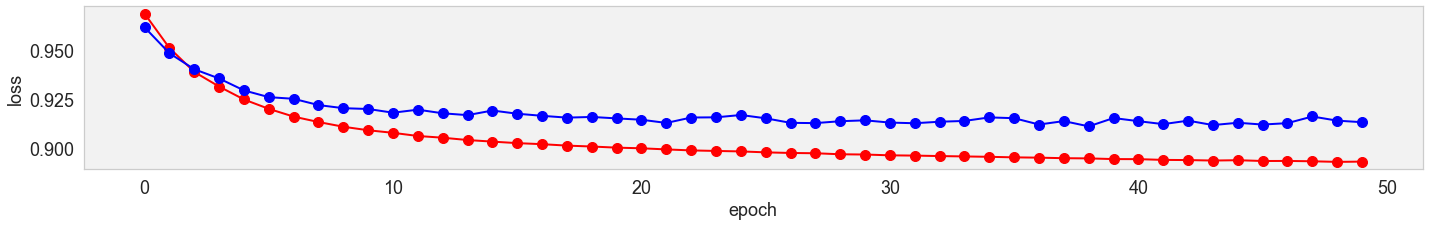

In [34]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

No handles with labels found to put in legend.


Text(0.5, 0, 'epoch')

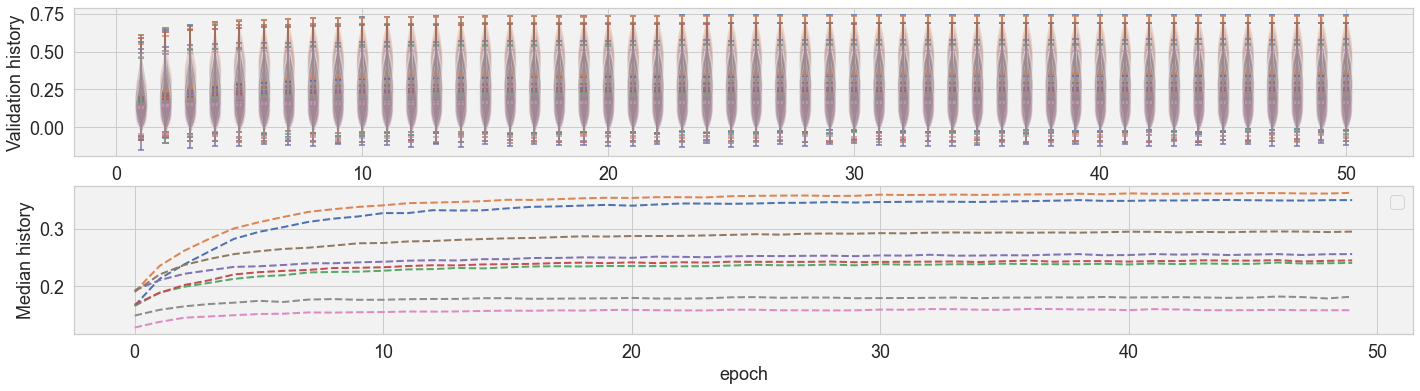

In [35]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [36]:
val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 100
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel, val_stim_ordering, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.255
best joint val cc = 0.282
subject 1: val cc = 0.361
subject 2: val cc = 0.338
subject 3: val cc = 0.297
subject 4: val cc = 0.261
subject 5: val cc = 0.289
subject 6: val cc = 0.268
subject 7: val cc = 0.241
subject 8: val cc = 0.213


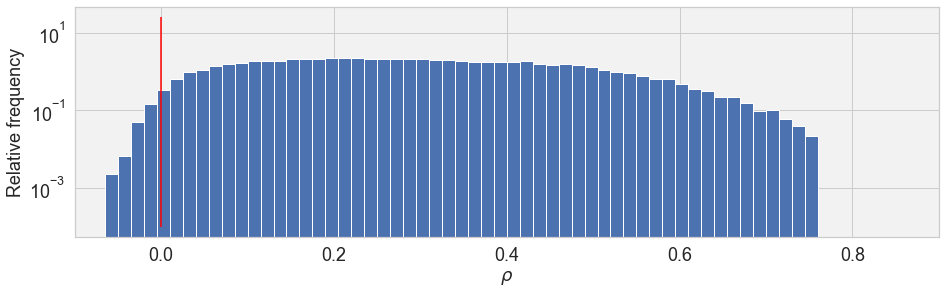

In [37]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [38]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, output_dir+'model_params')

In [39]:
print (output_dir)

/export/raid1/home/styvesg/code/nsd/output/multisubject/gnet8jdev_mpf_evc_Jan-27-2022_1744/


In [40]:
joined_val_ccs = subject_val_cc

---
# Reload this GNet8j validation accuracy

In [43]:
roi_group_names = ['V1', 'V2', 'V3', 'V4']
roi_group = [[1,2],[3,4],[5,6], [7]]

from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [6]:
#joined_dir = root_dir+"output/multisubject/gnet_mpf_evc_Jan-14-2022_1037/"
#output_dir = root_dir+"output/multisubject/gnet_mpf_evc_Jan-14-2022_1037/"

joined_dir = "../../results/nsd/multisubject/gnet_mpf_evc_May-23-2021_0945/"
output_dir = root_dir+'output/multisubject/gnet8r_mpf_evc_Jan-17-2022_1738'

checkpoint = torch.load(joined_dir + "model_params")
joined_val_ccs = checkpoint['val_cc']
voxel_roi  = checkpoint['voxel_roi']

# Load Previous GNet8j validation accuracy

In [41]:
old_joined_dir = root_dir + "../../results/nsd/multisubject/gnet_mpf_evc_May-23-2021_0945/"

checkpoint = torch.load(old_joined_dir + "model_params")
old_joined_val_ccs = checkpoint['val_cc']

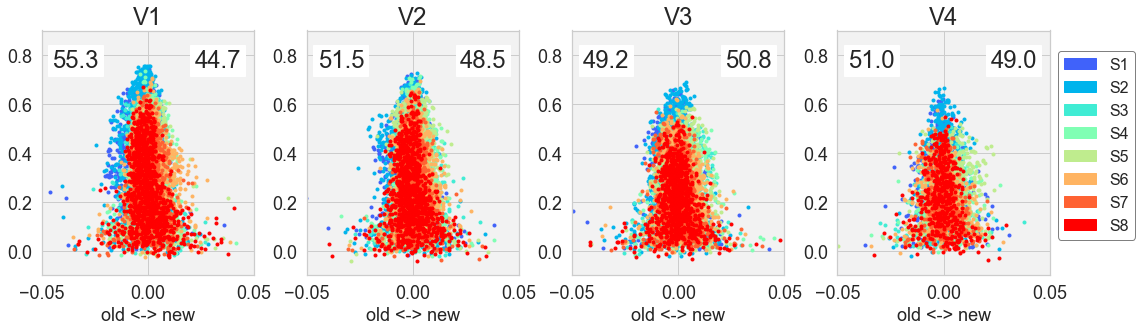

In [44]:
fig=plt.figure(figsize=(20,4))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.85, top=.95, wspace=0.25, hspace=0.25)
XY_roi_compare = {roi: [] for roi in roi_group_names}
axes = [plt.subplot(1,4,i+1) for i in range(len(roi_group_names))]

for k,s in enumerate(trn_subjects):
    
    X = joined_val_ccs[s]
    Y = old_joined_val_ccs[s]

    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, voxel_roi[s], roi_map, roi_group_names)):                
        plt.sca(axes[i])
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((X+Y)/2)[mask], linestyle='None', marker='.', color=subj_cmap[s])
    
        XY_roi_compare[roi_name] += [(X - Y)[mask],]

        plt.xlim([-.05,.05])
        plt.ylim([-.1,.9])
        plt.title(roi_name)
    
for i,roi_name in enumerate(roi_group_names):
    plt.sca(axes[i])
    X = np.concatenate(XY_roi_compare[roi_name])
    plt.text(-.045, .75, '%.01f'%(np.sum(X<0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.text(.022, .75, '%.01f'%(np.sum(X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.xlabel('old <-> new')
                
plt.sca(axes[-1])          
legend_elements = [Patch(facecolor=subj_cmap[s], edgecolor=subj_cmap[s], label='S%d'%s) for s in trn_subjects]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [49]:
filename = output_dir + 'gnet8j128_v_gnet8j64_validation_accuracies%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Load ROI-wise validation accuracy

In [51]:
#roiwise_dir = root_dir+'output/multisubject/gnet8r_mpf_evc_Jan-14-2022_1057' # 832
roiwise_dir = root_dir+'output/multisubject/gnet8r64_mpf_evc_Jan-16-2022_1511' # 512

#roiwise_dir = root_dir+'output/multisubject/gnet8r_mpf_evc_Jan-17-2022_1738' # 512
#roiwise_dir = root_dir+'output/multisubject/gnet8r128_mpf_evc_Jan-21-2022_2301'

In [52]:
roi_timestamp_dir = {
    'V1': '%s/model_params_V1' % roiwise_dir,
    'V2': '%s/model_params_V2' % roiwise_dir,
    'V3': '%s/model_params_V3' % roiwise_dir,
    'hV4': '%s/model_params_hV4' % roiwise_dir
    }

In [53]:
checkpoint = {}
for r,t in roi_timestamp_dir.items():
    checkpoint[r] = torch.load(t)

In [54]:
roiwise_val_ccs = {s: np.zeros_like(v) for s,v in voxel_roi.items()}

for k,(roi_name, cp) in enumerate(checkpoint.items()):
    for subj in voxel_roi.keys():
    #    roi_mask = list(iterate_roi(group, voxel_roi[subj], roi_map, group_name=group_names))[k][0]        
    
        roi_mask = cp['group_mask'][subj]
        roiwise_val_ccs[subj][roi_mask] = cp['val_cc'][subj]

# Comparison

In [55]:
from matplotlib import cm
from matplotlib.patches import Patch

subjects = [1,2,3,4,5,6,7,8]
roi_cmap = [cm.get_cmap('rainbow', 5)(0), cm.get_cmap('rainbow', 5)(1), cm.get_cmap('rainbow', 5)(3), cm.get_cmap('rainbow', 5)(4)]
subj_cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(len(subjects)+1)]

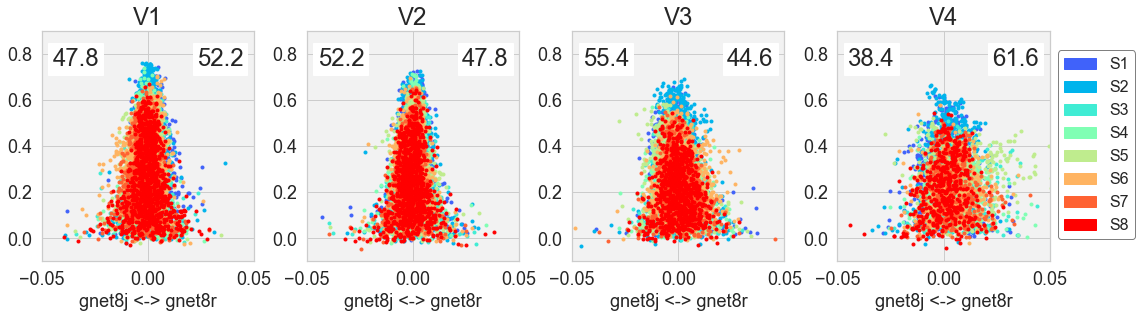

In [56]:
fig=plt.figure(figsize=(20,4))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.85, top=.9, wspace=0.25, hspace=0.25)
XY_roi_compare = {roi: [] for roi in roi_group_names}
axes = [plt.subplot(1,4,i+1) for i in range(len(roi_group_names))]

for k,s in enumerate(subjects):
    
    Y = joined_val_ccs[s]
    X = roiwise_val_ccs[s]

    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, voxel_roi[s], roi_map, roi_group_names)):                
        plt.sca(axes[i])
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((X+Y)/2)[mask], linestyle='None', marker='.', color=subj_cmap[s])
    
        XY_roi_compare[roi_name] += [(X - Y)[mask],]

        plt.xlim([-.05,.05])
        plt.ylim([-.1,.9])
        plt.title(roi_name)
    
for i,roi_name in enumerate(roi_group_names):
    plt.sca(axes[i])
    X = np.concatenate(XY_roi_compare[roi_name])
    plt.text(-.045, .75, '%.01f'%(np.sum(X<0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.text(.023, .75, '%.01f'%(np.sum(X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.xlabel('gnet8j <-> gnet8r')
                
plt.sca(axes[-1])          
legend_elements = [Patch(facecolor=subj_cmap[s], edgecolor=subj_cmap[s], label='S%d'%s) for s in subjects]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [57]:
filename = output_dir + 'gnet8r_v_gnet8j_validation_accuracies%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Load cross-ROI models

In [58]:
group_names = ['V1', 'V2', 'V3', 'hV4']
group = [[1,2], [3,4], [5,6], [7]]

crossroi_val_ccs = {}
for roi_name in ['V1', 'V2', 'V3', 'hV4']:
    checkpoint = torch.load('%s/%s/model_params'%(roiwise_dir, roi_name) )
    crossroi_val_ccs[roi_name] = checkpoint['val_cc']

# Subjectwise cross-model matrix

In [59]:
subj_val_mat = {s: np.zeros(shape=(len(roi_group_names), len(roi_group_names))) for s in voxel_roi.keys()}
all_mat = np.zeros(shape=(len(roi_group_names), len(roi_group_names)))
all_count = np.zeros(shape=(len(roi_group_names), len(roi_group_names)))
for i,(i_roi_name, val_cc) in enumerate(crossroi_val_ccs.items()):
    print ('%d - %s'%(i, i_roi_name))
    for s, v in val_cc.items():
        for j, (roi_mask, j_roi_name) in enumerate(iterate_roi(group, voxel_roi[s], roi_map)):
            #print ('  %d - %s'%(j, j_roi_name))
            subj_val_mat[s][i,j] = np.mean(v[roi_mask] -  roiwise_val_ccs[s][roi_mask])
            all_mat[i,j] += np.sum(v[roi_mask] -  roiwise_val_ccs[s][roi_mask])
            all_count[i,j] += np.sum(roi_mask)

0 - V1
1 - V2
2 - V3
3 - hV4


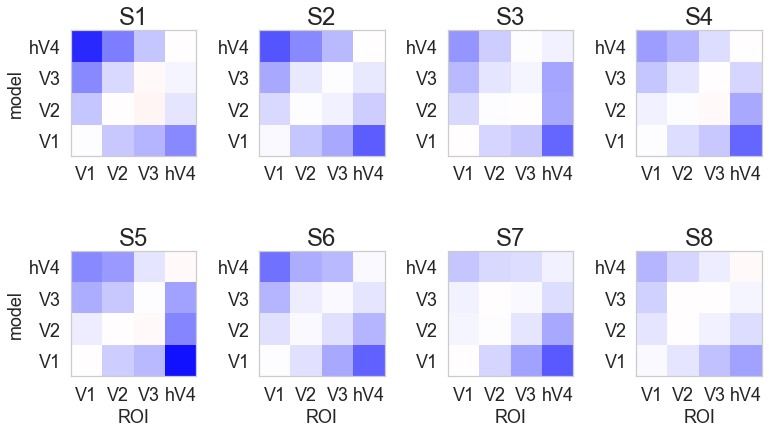

In [60]:
# line = model
# column = roi

fig=plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

for k,(s,mat) in enumerate(subj_val_mat.items()):
    plt.subplot(2,4,k+1)
    plt.imshow(mat, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
    plt.grid(False)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(group_names)))
    ax.set_xticklabels(group_names)
    ax.set_yticks(np.arange(len(group_names)))
    ax.set_yticklabels(group_names)
    if k%4==0:
        plt.ylabel('model')
    if k>=4:
        plt.xlabel('ROI')
    plt.title('S%s'%s)
    #if (k+1)%4==0:
    #    plt.colorbar()

In [61]:
filename = output_dir + 'gnet8r_xmodel_table%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

Text(0.5, 0, 'ROI')

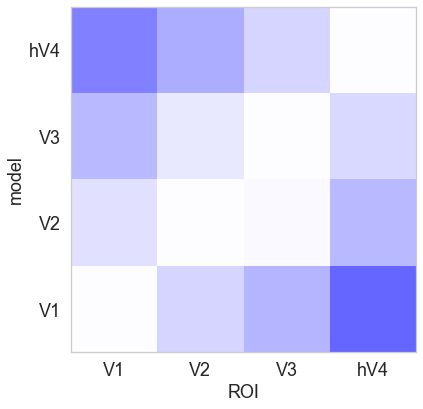

In [62]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

plt.imshow(all_mat/all_count, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
plt.grid(False)
ax = plt.gca()
ax.set_xticks(np.arange(len(group_names)))
ax.set_xticklabels(group_names)
ax.set_yticks(np.arange(len(group_names)))
ax.set_yticklabels(group_names)
plt.ylabel('model')
plt.xlabel('ROI')

In [63]:
filename = output_dir + 'gnet8r_xmodel_table_all%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Characterization

In [64]:
D_mat = np.array([[0,1,2,3], [1,0,1,2], [2,1,0,1],  [3,2,1,0]])
D_up_tri_mat = np.array([[0,0,0,0], [1,0,0,0], [2,1,0,0], [3,2,1,0]])
D_dn_tri_mat = np.array([[0,1,2,3], [0,0,1,2], [0,0,0,1], [0,0,0,0]])

from scipy.optimize import curve_fit
def fit_fn(x, a):
    return a*x

alpha, dalpha = {}, {}
for s,m in subj_val_mat.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

1 : -0.35507520165603434 +/- 0.08615757788058727
2 : -0.10365062891315469 +/- 0.08108038795093028
3 : 0.16882191926778178 +/- 0.11489147366490643
4 : 0.1230630222285967 +/- 0.09391677263170858
5 : 0.20420469998304683 +/- 0.11390567568448351
6 : 0.01822345525525168 +/- 0.0653780906187199
7 : 0.5116209304938658 +/- 0.08555558335550065
8 : 0.08978884619315365 +/- 0.08338005897440767


In [65]:
for s,m in {'all': all_mat/all_count}.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

all : 0.041789717187124396 +/- 0.06576130661185692
